In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

from torch.utils.data import DataLoader, Subset
from torch import optim
from torchvision import transforms, datasets
from scipy.special import softmax
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Experiment: Does Removing More Data Increase Uncertainty?

This notebook investigates whether removing different proportions of training data (5%, 10%, 15%, 20%) using MC dropout uncertainty estimation and first-order based unlearning consistently increases uncertainty.

Dataset: CIFAR-10 with a CNN
Uncertainty Method: MC Dropout
Unlearning Method: First-order based
Metrics: ECE (Expected Calibration Error) and BS (Brier Score)
Each experiment runs 3 times with mean ± standard deviation reported.

In [3]:
# Setup GPU device
if torch.cuda.is_available():
    cudnn.benchmark = True
    device = "cuda:0"
else:
    device = "cpu"
print(f'Device: {device}')

# Set random seed for reproducibility
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

Device: cpu


## Load Dataset

In [4]:
# Load CIFAR-10 dataset
data_mean = (0.4914, 0.4822, 0.4465)
data_std = (0.2023, 0.1994, 0.2010)
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std), ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std), ])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split test set into calibration and test
cali_indices, test_indices = train_test_split(
    range(len(test_set)),
    test_size=0.5,
    stratify=test_set.targets,
)

cali_data = Subset(test_set, cali_indices)
test_data = Subset(test_set, test_indices)

num_classes = 10
batch_size = 128

# Dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
cali_loader = DataLoader(cali_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f'Training data length: {len(train_data)}, calibration data length: {len(cali_data)}, test data length: {len(test_data)}')

100.0%


Training data length: 50000, calibration data length: 5000, test data length: 5000


## Define Model

In [5]:
# Build a simple convolutional neural network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, dropout=False):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        if dropout:
            x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training and Utility Functions

In [6]:
# Training function
def train(model, train_loader, loss_func, optimizer, epochs):
    model.train()
    loss_all = []
    for epoch in range(epochs):
        model.train()
        running_loss, n_batches, total, correct = 0.0, 0, 0, 0
    
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            n_batches += 1
    
        loss = running_loss / n_batches
        accuracy = 100 * correct / total
        if epoch % 5 == 0:
            print('Epoch %d training loss: %.3f training accuracy: %.3f%%' % (epoch, loss, accuracy))
    
        loss_all.append(loss)

    return loss_all

# Test function
def test(model, test_loader):
    model.eval()
    total, correct = 0, 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

# Helper for one-hot encoding
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = len(np.unique(labels))
    return np.eye(num_classes)[labels]

# ECE calculation
def get_calibration_error(probs, labels, bin_upper_bounds, num_bins):
    if np.size(probs) == 0:
        return 0

    bin_indices = np.digitize(probs, bin_upper_bounds)
    sums = np.bincount(bin_indices, weights=probs, minlength=num_bins)
    sums = sums.astype(np.float64)
    counts = np.bincount(bin_indices, minlength=num_bins)
    counts = counts + np.finfo(sums.dtype).eps
    confs = sums / counts
    accs = np.bincount(bin_indices, weights=labels, minlength=num_bins) / counts

    calibration_errors = accs - confs
    weighting = counts / float(len(probs.flatten()))
    weighted_calibration_error = calibration_errors * weighting

    return np.sum(np.abs(weighted_calibration_error))

def ECE(probs, labels, num_bins=10):
    num_classes = probs.shape[1]
    labels_matrix = one_hot_encode(labels, probs.shape[1])

    bin_upper_bounds = np.histogram_bin_edges([], bins=num_bins, range=(0.0, 1.0))[1:]

    labels_matrix = labels_matrix[range(len(probs)), np.argmax(probs, axis=1)]
    probs_matrix = probs[range(len(probs)), np.argmax(probs, axis=1)]

    calibration_error = get_calibration_error(probs_matrix.flatten(), labels_matrix.flatten(), bin_upper_bounds, num_bins)

    return calibration_error

# Brier Score calculation
def BS(probs, labels):
    n_samples, n_classes = probs.shape
    labels_matrix = one_hot_encode(labels, n_classes)
    brier_score = np.sum((probs - labels_matrix) ** 2) / n_samples

    return brier_score

# Get outputs from model
def get_outputs(model, data_loader):
    model.eval()
    all_labels, all_logits = [], []

    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.append(labels.detach().cpu().numpy())
            all_logits.append(outputs.detach().cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_logits = np.concatenate(all_logits, axis=0)

    return all_labels, all_logits

## MC Dropout Uncertainty Estimation

In [7]:
# MC Dropout uncertainty estimation
def evaluate_dropout(model, test_loader, forward_passes=10):
    def enable_dropout(model):
        """ Function to enable the dropout layers during test-time """
        for m in model.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()

    def get_outputs_dropout(model, data_loader):
        all_labels, all_logits = [], []
        model.eval()
        enable_dropout(model)
        with torch.no_grad():
            for idx, (images, labels) in enumerate(data_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, dropout=True)

                all_labels.append(labels.detach().cpu().numpy())
                all_logits.append(outputs.detach().cpu().numpy())

            all_labels = np.concatenate(all_labels, axis=0)
            all_logits = np.concatenate(all_logits, axis=0)

        return all_labels, all_logits

    test_probs = []
    for i in range(forward_passes):
        test_labels, test_logits = get_outputs_dropout(model, test_loader)
        test_probs.append(softmax(test_logits, axis=1))

    test_probs = np.array(test_probs)
    test_probs_mean = test_probs.mean(0)

    ece = ECE(test_probs_mean, test_labels)
    bs = BS(test_probs_mean, test_labels)

    return ece, bs, test_probs_mean, test_labels

## First-Order Based Unlearning

In [8]:
# First-order based unlearning
def get_grad_diff(model, unlearn_loader):
    loss_func = nn.CrossEntropyLoss(reduction="sum")
    model.train()
    grads = []

    for i, (images, labels) in enumerate(unlearn_loader):
        images, labels = images.to(device), labels.to(device)

        result_z = model(images)
        loss_z = loss_func(result_z, labels)
        loss_diff = -loss_z

        differentiable_params = [p for p in model.parameters() if p.requires_grad]
        gradients = torch.autograd.grad(loss_diff, differentiable_params)
        grads.append(gradients)

    # add all grads from batch
    grads = list(zip(*grads))
    for i in range(len(grads)):
        tmp = grads[i][0]
        for j in range(1, len(grads[i])):
            tmp = torch.add(tmp, grads[i][j])
        grads[i] = tmp

    return grads

def first_order_unlearn(model, unlearn_loader, tau=0.00002):
    net_unlearn = copy.deepcopy(model)
    diff = get_grad_diff(net_unlearn, unlearn_loader)
    d_theta = diff

    net_unlearn.eval()
    with torch.no_grad():
        for p in net_unlearn.parameters():
            if p.requires_grad:
                new_p = p - tau * d_theta.pop(0)
                p.copy_(new_p)

    return net_unlearn

## Main Experiment: Remove Different Proportions of Data

In [9]:
# Experiment parameters
proportions_to_remove = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20%
num_runs = 3  # Run each experiment 3 times
epochs = 20
lr = 0.01
forward_passes = 10  # MC dropout forward passes

# Store results: {proportion: {'ECE': [...], 'BS': [...]}}
results = {prop: {'ECE': [], 'BS': []} for prop in proportions_to_remove}

print("=" * 80)
print("Starting Experiment: Does Removing More Data Increase Uncertainty?")
print("=" * 80)

for prop_to_remove in proportions_to_remove:
    print(f"\n{'='*80}")
    print(f"Testing removal proportion: {prop_to_remove*100:.0f}%")
    print(f"{'='*80}")
    
    for run_num in range(num_runs):
        print(f"\n--- Run {run_num + 1}/{num_runs} ---")
        set_random_seed(42 + run_num)
        
        # Train baseline model on full dataset
        print("Training baseline model on full dataset...")
        model = SimpleCNN().to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        train(model, train_loader, loss_func, optimizer, epochs)
        
        # Evaluate baseline with MC dropout
        print("Evaluating baseline model with MC dropout...")
        ece_baseline, bs_baseline, _, _ = evaluate_dropout(model, test_loader, forward_passes=forward_passes)
        print(f"  Baseline - ECE: {ece_baseline:.4f}, BS: {bs_baseline:.4f}")
        
        # Select data to unlearn (random sampling)
        num_samples = len(train_data)
        sample_size = int(num_samples * prop_to_remove)
        
        indices = list(range(num_samples))
        unlearn_indices = random.sample(indices, sample_size)
        unlearn_data = Subset(train_data, unlearn_indices)
        
        retain_indices = [idx for idx in range(num_samples) if idx not in unlearn_indices]
        retain_data = Subset(train_data, retain_indices)
        
        unlearn_loader = DataLoader(unlearn_data, batch_size=128, shuffle=False)
        retain_loader = DataLoader(retain_data, batch_size=128, shuffle=True)
        
        print(f"Unlearning {len(unlearn_data)} samples ({prop_to_remove*100:.0f}%), retaining {len(retain_data)} samples")
        
        # Apply first-order unlearning
        print("Applying first-order unlearning...")
        model_unlearned = first_order_unlearn(model, unlearn_loader, tau=0.00002)
        
        # Evaluate unlearned model with MC dropout
        print("Evaluating unlearned model with MC dropout...")
        ece_unlearned, bs_unlearned, _, _ = evaluate_dropout(model_unlearned, test_loader, forward_passes=forward_passes)
        print(f"  Unlearned - ECE: {ece_unlearned:.4f}, BS: {bs_unlearned:.4f}")
        
        # Store results
        results[prop_to_remove]['ECE'].append(ece_unlearned)
        results[prop_to_remove]['BS'].append(bs_unlearned)

print("\n" + "=" * 80)
print("Experiment completed!")
print("=" * 80)

Starting Experiment: Does Removing More Data Increase Uncertainty?

Testing removal proportion: 5%

--- Run 1/3 ---
Training baseline model on full dataset...
Epoch 0 training loss: 1.811 training accuracy: 34.580%
Epoch 5 training loss: 1.017 training accuracy: 63.942%
Epoch 10 training loss: 0.777 training accuracy: 72.690%
Epoch 15 training loss: 0.624 training accuracy: 78.076%
Evaluating baseline model with MC dropout...
  Baseline - ECE: 0.0366, BS: 0.4525
Unlearning 2500 samples (5%), retaining 47500 samples
Applying first-order unlearning...
Evaluating unlearned model with MC dropout...
  Unlearned - ECE: 0.0115, BS: 0.4802

--- Run 2/3 ---
Training baseline model on full dataset...
Epoch 0 training loss: 1.822 training accuracy: 34.132%
Epoch 5 training loss: 1.009 training accuracy: 64.246%
Epoch 10 training loss: 0.758 training accuracy: 73.300%
Epoch 15 training loss: 0.599 training accuracy: 78.990%
Evaluating baseline model with MC dropout...
  Baseline - ECE: 0.0317, BS:

## Results Analysis and Reporting

In [17]:
print("\n" + "=" * 80)
print("SUMMARY OF RESULTS: Uncertainty Metrics After Unlearning")
print("=" * 80)
print(f"\nExperiment Settings:")
print(f"  - Proportions removed: {[f'{p*100:.0f}%' for p in proportions_to_remove]}")
print(f"  - Number of runs per proportion: {num_runs}")
print(f"  - Uncertainty method: MC Dropout ({forward_passes} forward passes)")
print(f"  - Unlearning method: First-order based")
print()

stats = {}
print(f"{'Proportion':<12} {'ECE (mean ± std)':<24} {'BS (mean ± std)':<24}")
print('-' * 70)
for prop in proportions_to_remove:
    stats[prop] = {}
    ece_vals = np.array(results[prop]['ECE'])
    bs_vals = np.array(results[prop]['BS'])
    ece_mean, ece_std = float(np.mean(ece_vals)), float(np.std(ece_vals))
    bs_mean, bs_std = float(np.mean(bs_vals)), float(np.std(bs_vals))
    stats[prop]['ECE'] = {'mean': ece_mean, 'std': ece_std}
    stats[prop]['BS'] = {'mean': bs_mean, 'std': bs_std}
    ece_label = f"{ece_mean:.4f} ± {ece_std:.4f}"
    bs_label = f"{bs_mean:.4f} ± {bs_std:.4f}"
    print(f"{int(prop*100):>3}%{'':<8} {ece_label:<24} {bs_label:<24}")

print("\nRaw Results (all runs):")
for prop in proportions_to_remove:
    print(f"\nProportion: {prop*100:.0f}%")
    print(f"  ECE values: {[f'{v:.4f}' for v in results[prop]['ECE']]}")
    print(f"  BS values:  {[f'{v:.4f}' for v in results[prop]['BS']]}")


SUMMARY OF RESULTS: Uncertainty Metrics After Unlearning

Experiment Settings:
  - Proportions removed: ['5%', '10%', '15%', '20%']
  - Number of runs per proportion: 3
  - Uncertainty method: MC Dropout (10 forward passes)
  - Unlearning method: First-order based

Proportion   ECE (mean ± std)         BS (mean ± std)         
----------------------------------------------------------------------
  5%         0.0148 ± 0.0063          0.4823 ± 0.0066         
 10%         0.0540 ± 0.0195          0.5399 ± 0.0227         
 15%         0.1123 ± 0.0258          0.6130 ± 0.0367         
 20%         0.1891 ± 0.0463          0.7068 ± 0.0677         

Raw Results (all runs):

Proportion: 5%
  ECE values: ['0.0115', '0.0236', '0.0092']
  BS values:  ['0.4802', '0.4912', '0.4754']

Proportion: 10%
  ECE values: ['0.0367', '0.0813', '0.0441']
  BS values:  ['0.5318', '0.5708', '0.5171']

Proportion: 15%
  ECE values: ['0.0909', '0.1486', '0.0974']
  BS values:  ['0.5989', '0.6633', '0.5769']

P

## Visualization: Line Charts with Error Bars

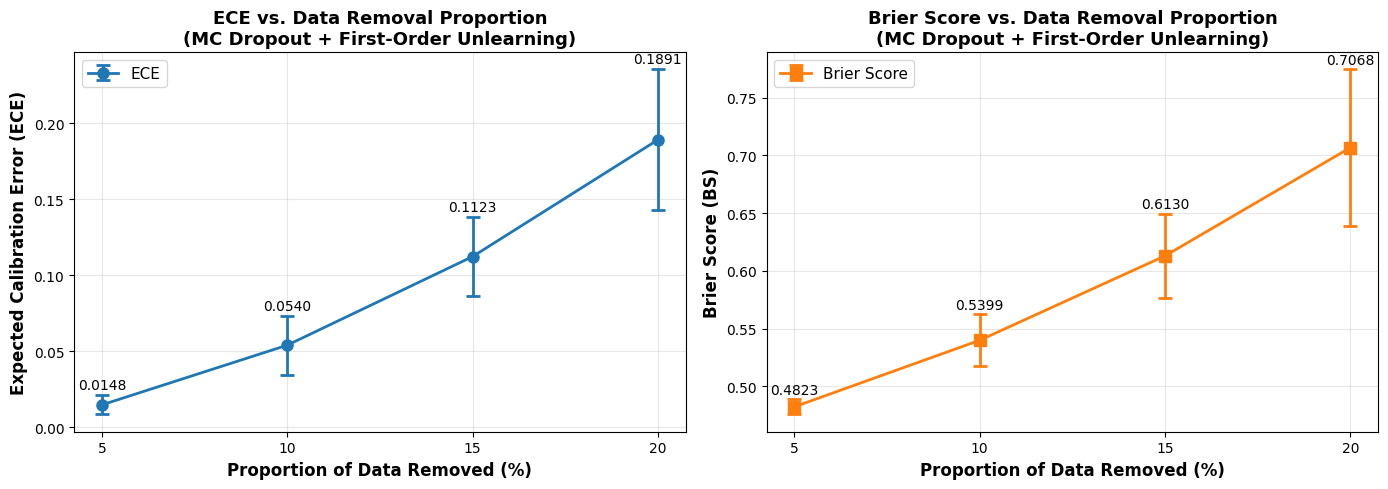


Visualization saved as 'uncertainty_vs_data_removal.png'


In [11]:
# Prepare data for visualization
proportions_pct = [p * 100 for p in proportions_to_remove]
ece_means = [stats[prop]['ECE']['mean'] for prop in proportions_to_remove]
ece_stds = [stats[prop]['ECE']['std'] for prop in proportions_to_remove]
bs_means = [stats[prop]['BS']['mean'] for prop in proportions_to_remove]
bs_stds = [stats[prop]['BS']['std'] for prop in proportions_to_remove]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ECE plot
ax1 = axes[0]
ax1.errorbar(proportions_pct, ece_means, yerr=ece_stds, fmt='o-', linewidth=2, markersize=8, 
             color='#1f77b4', ecolor='#1f77b4', capsize=5, capthick=2, label='ECE')
ax1.set_xlabel('Proportion of Data Removed (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Expected Calibration Error (ECE)', fontsize=12, fontweight='bold')
ax1.set_title('ECE vs. Data Removal Proportion\n(MC Dropout + First-Order Unlearning)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(proportions_pct)
ax1.legend(fontsize=11)

# Add value labels on points
for i, (x, y) in enumerate(zip(proportions_pct, ece_means)):
    ax1.text(x, y + ece_stds[i] + 0.002, f'{y:.4f}', ha='center', va='bottom', fontsize=10)

# BS plot
ax2 = axes[1]
ax2.errorbar(proportions_pct, bs_means, yerr=bs_stds, fmt='s-', linewidth=2, markersize=8,
             color='#ff7f0e', ecolor='#ff7f0e', capsize=5, capthick=2, label='Brier Score')
ax2.set_xlabel('Proportion of Data Removed (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Brier Score (BS)', fontsize=12, fontweight='bold')
ax2.set_title('Brier Score vs. Data Removal Proportion\n(MC Dropout + First-Order Unlearning)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(proportions_pct)
ax2.legend(fontsize=11)

# Add value labels on points
for i, (x, y) in enumerate(zip(proportions_pct, bs_means)):
    ax2.text(x, y + bs_stds[i] + 0.002, f'{y:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('uncertainty_vs_data_removal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'uncertainty_vs_data_removal.png'")

## Analysis and Conclusions

In [12]:
# Analysis
print("\n" + "=" * 80)
print("KEY FINDINGS AND ANALYSIS")
print("=" * 80)

# Check if uncertainty increases with data removal
ece_trend = ece_means[-1] - ece_means[0]
bs_trend = bs_means[-1] - bs_means[0]

print(f"\n1. UNCERTAINTY TRENDS:")
print(f"   - ECE change (5% → 20% removal): {ece_trend:+.4f} ({(ece_trend/ece_means[0]*100):+.1f}%)")
print(f"     {'↑ ECE increases (higher uncertainty)' if ece_trend > 0 else '↓ ECE decreases (lower uncertainty)'}")
print(f"   - BS change (5% → 20% removal):  {bs_trend:+.4f} ({(bs_trend/bs_means[0]*100):+.1f}%)")
print(f"     {'↑ BS increases (higher uncertainty)' if bs_trend > 0 else '↓ BS decreases (lower uncertainty)'}")

print(f"\n2. CONSISTENCY ACROSS RUNS:")
print(f"   - Average ECE std dev across proportions: {np.mean(ece_stds):.4f}")
print(f"   - Average BS std dev across proportions:  {np.mean(bs_stds):.4f}")
print(f"   - ECE consistency: {'Good (low variance)' if np.mean(ece_stds) < 0.005 else 'Moderate' if np.mean(ece_stds) < 0.01 else 'High variance'}")
print(f"   - BS consistency:  {'Good (low variance)' if np.mean(bs_stds) < 0.005 else 'Moderate' if np.mean(bs_stds) < 0.01 else 'High variance'}")

print(f"\n3. MONOTONICITY CHECK:")
# Check if trend is monotonic
ece_monotonic = all(ece_means[i] <= ece_means[i+1] for i in range(len(ece_means)-1))
bs_monotonic = all(bs_means[i] <= bs_means[i+1] for i in range(len(bs_means)-1))

print(f"   - ECE monotonically increases: {'Yes' if ece_monotonic else 'No (non-monotonic behavior detected)'}")
print(f"   - BS monotonically increases:  {'Yes' if bs_monotonic else 'No (non-monotonic behavior detected)'}")

print(f"\n4. SUMMARY:")
if ece_trend > 0 and bs_trend > 0:
    print(f"   ✓ CONSISTENT: Removing more data INCREASES uncertainty (both ECE and BS)")
    print(f"     This suggests that unlearning more data leads to less confident predictions.")
elif ece_trend < 0 and bs_trend < 0:
    print(f"   ✗ COUNTER-INTUITIVE: Removing more data DECREASES uncertainty")
    print(f"     This suggests unexpected model behavior under unlearning.")
else:
    print(f"   ≈ MIXED RESULTS: ECE and BS show opposite trends")
    print(f"     Further investigation needed.")

print("\n" + "=" * 80)


KEY FINDINGS AND ANALYSIS

1. UNCERTAINTY TRENDS:
   - ECE change (5% → 20% removal): +0.1744 (+1181.2%)
     ↑ ECE increases (higher uncertainty)
   - BS change (5% → 20% removal):  +0.2245 (+46.6%)
     ↑ BS increases (higher uncertainty)

2. CONSISTENCY ACROSS RUNS:
   - Average ECE std dev across proportions: 0.0245
   - Average BS std dev across proportions:  0.0334
   - ECE consistency: High variance
   - BS consistency:  High variance

3. MONOTONICITY CHECK:
   - ECE monotonically increases: Yes
   - BS monotonically increases:  Yes

4. SUMMARY:
   ✓ CONSISTENT: Removing more data INCREASES uncertainty (both ECE and BS)
     This suggests that unlearning more data leads to less confident predictions.

